In [1]:
!pip install allantools

# Description of Signal #

Consider an ideal MEMS gyroscope. Angle rate measurements from the gyroscope can be modeled according to

$\Omega$(t) = $\Omega_{ideal}$(t) + Bias$_{N}$ + Bias$_{B}$ + Bias$_{K}$

for 
- N: angle random walk
- K: rate random walk
- B: bias instability.

The focus of this notebook is to model the bias terms and verify their characteristics by calculating Allan variance $\sigma^{2}(\tau)$ of the sum of the signals. Then, these noise models can be used to model a real world gyroscope.

# Angle Random Walk #

The Allan variance is useful calculation for identifying various types of noise polluting a measurement signal. There is a known relationship between the noise power spectral density (PSD) and the Allan variance. So, noise can be identified via the slope each noise source contributes to an Allan deviation plot.

The angle random walk can be modeled by a white noise sequence. Using the known relation, we arrive at  
$\sigma(\tau) = \frac{N}{\sqrt{\tau}}$ for the Allan deviation of a white noise series. 

Plotting this equation on a log-log plot will produce a line with slope -1/2, since $\sigma(\tau) \propto \tau^{\frac{-1}{2}}$

We start by creating a pseudo-random series with the characteristics of a white noise series.

In [2]:
from random import gauss
from random import seed
from pandas import Series 

In [3]:
#seed the random number generator to get the same results on repeated trials
seed(12)

In [4]:
#number of values in the white noise series
nSamples = 2.5e6

In [5]:
#values of the white noise series
values = [gauss(0, 1) for i in range(0, int(nSamples))]
#package the values into a pandas Series
series = Series(data=values)
#let pandas handle calculating summary statistics
series.describe()

count    2.500000e+06
mean     7.964356e-04
std      1.000081e+00
min     -4.973905e+00
25%     -6.743958e-01
50%      8.679537e-04
75%      6.751735e-01
max      5.065083e+00
dtype: float64

The summary statistics show that this series has a mean "near" 0.0 and a standard deviation of about 1.0. A perfect white noise series has mean exactly 0.0 and standard deviation exactly 1.0.

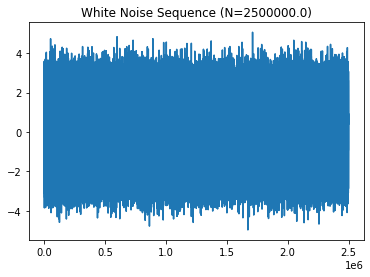

In [6]:
#view the series in full
series.plot(title=f"White Noise Sequence (N={nSamples})");

The values for this series were drawn from a Normal distribution. We can prove this by looking at the distribution of chosen values, below.

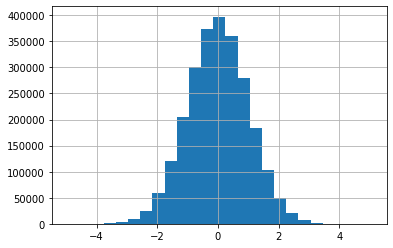

In [7]:
series.hist(bins=25);

# The Allan Deviation #

Below, I calculate the Allan deviation of the white noise. Once again, I expect a slope of -1/2.

In [8]:
import matplotlib.pyplot as plt
from allantools import adev
from allantools import oadev
import numpy as np

In [9]:
#sigma = adev(data=series[:-1], rate=1/data_type="phase")
sigma = oadev(data=series)

In [10]:
taus2, adev = (sigma[0], sigma[1])
taus2, adev

(array([1.000000e+00, 2.000000e+00, 4.000000e+00, 8.000000e+00,
        1.600000e+01, 3.200000e+01, 6.400000e+01, 1.280000e+02,
        2.560000e+02, 5.120000e+02, 1.024000e+03, 2.048000e+03,
        4.096000e+03, 8.192000e+03, 1.638400e+04, 3.276800e+04,
        6.553600e+04, 1.310720e+05, 2.621440e+05, 5.242880e+05,
        1.048576e+06]),
 array([1.73299993e+00, 8.65637325e-01, 4.32810153e-01, 2.16341171e-01,
        1.08302472e-01, 5.41241287e-02, 2.70740367e-02, 1.35202686e-02,
        6.77112096e-03, 3.38081864e-03, 1.69155937e-03, 8.45721130e-04,
        4.23014364e-04, 2.11579331e-04, 1.05626506e-04, 5.28700008e-05,
        2.64351191e-05, 1.32113296e-05, 6.60704632e-06, 3.30598500e-06,
        1.65079044e-06]))

In [11]:
adev = np.sqrt(adev)

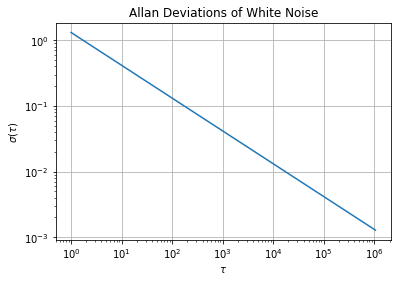

In [12]:
plt.loglog(taus2, adev)
plt.title("Allan Deviations of White Noise")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\sigma(\tau)$")
plt.grid(b=True)
plt.show()

Next, check the slope of the linear portion of the Allan deviation ($\tau\approx10$s to $\tau\approx25$s). A slope of -1/2 indicates white noise.

The simplest way to do this is to calculate the slope of the straight line passing through the linear portion of the graph. 

Notice that on a log-log scale, the equation for a straight line is a power law $y=bx^{m}$. On a log-log scale, $b$ is the y-coordinate of the y-intercept. Below is a function that estimates the y-intercept by averaging the product $b=y\cdot x^{-m}$ using known values of $x$ and $y$ from the calculated Allan deviation. 

In [13]:
#coordinate pairs of points for Allan deviation
adev_pairs = list(zip(taus2, adev))
adev_pairs

[(1.0, 1.3164345528309502),
 (2.0, 0.9303963269366691),
 (4.0, 0.6578830845904162),
 (8.0, 0.4651248978088826),
 (16.0, 0.3290934087901433),
 (32.0, 0.2326459299733629),
 (64.0, 0.16454189962345805),
 (128.0, 0.11627668980313773),
 (256.0, 0.08228682128003001),
 (512.0, 0.05814480752814489),
 (1024.0, 0.041128571195756164),
 (2048.0, 0.029081284872584143),
 (4096.0, 0.02056731300101037),
 (8192.0, 0.014545766783211947),
 (16384.0, 0.010277475660073516),
 (32768.0, 0.007271176024758519),
 (65536.0, 0.005141509417947953),
 (131072.0, 0.003634739273338587),
 (262144.0, 0.0025704175380340073),
 (524288.0, 0.0018182367841514816),
 (1048576.0, 0.0012848309011359727)]

In [14]:
def log_log_y_intercept(slice):

    """
    Estimate the y-intercept (on log-log scale) of the straight line containing 
    the points (x, y) in slice

    Args:
        slice (ndarray):  Numpy array containing coordinates of the calculated
                                Allan deviation as `float64`

    Returns:
        (numpy.float64):  Estimate of the intercept as a single `numpy.float64` 
    """

    return np.mean([p[0]*p[1] for p in slice])

In [15]:
#y-intercept for line passing through Allan deviation between 10s and 25s 
adev_intercept = log_log_y_intercept(adev_pairs[:5])
adev_intercept

2.959050653635862

Use the estimated y-intercept to plot a straight line with desired slope

In [16]:
def log_log_straight_line(slope, intercept, x=np.arange(1, 1000)):

    """
    Generate plottable points for a straight line (log-log scale) with a given
    slope and y-intercept. 

    Args:
        slope (float):  The desired slope of the straight line
        intercept (float):  The y-coordinate of the y-intercept for the desired line
        x (ndarray, optional):  Inputs to the power law. Defaults to `np.arange(1, 1000))`

    Returns:
        (ndarray):  Numpy array containing the output of a power law
    """

    return intercept*(x**slope)

In [17]:
#expect that slope -0.5 to be parallel with Allan deviation
slope_half = log_log_straight_line(-0.5, adev_intercept)

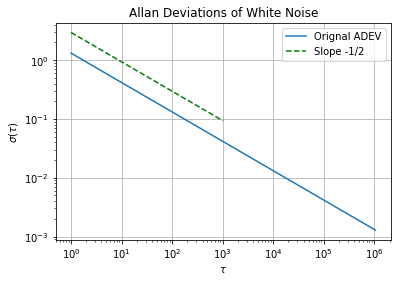

In [18]:
#inputs for plotting a power law
x = np.arange(1, 1000)

#plot both the straight line with slope -1/2 and Allan deviation
plt.loglog(taus2, adev, label="Orignal ADEV")
plt.loglog(x, slope_half, linestyle="dashed", color="green", label="Slope -1/2") #may change color in the future to account for color blindness

plt.legend()
plt.title("Allan Deviations of White Noise")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\sigma(\tau)$")
plt.grid(b=True)
plt.show()

The Allan deviation clearly has a steeper slope than -1/2.

The white noise sequence under study has only 10000 samples. So, it's likely that *quantisation noise* is to blame for the steeper slope. Quantisation noise appears as slope -1 on an Allan deviation plot.

The procedure above can be used to verify if quantisation noise appears here.

In [19]:
#straight line (log-log scale) with slope -1
slope_neg_one = log_log_straight_line(-1.0, adev_intercept)

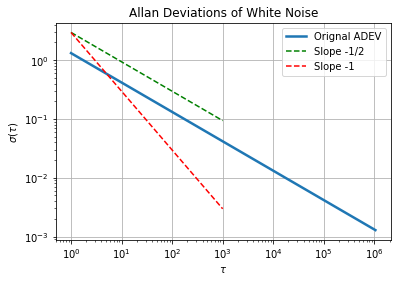

In [20]:
plt.loglog(taus2, adev, label="Orignal ADEV", linewidth=2.5)
plt.loglog(x, slope_half, linestyle="dashed", color="green", label="Slope -1/2")
plt.loglog(x, slope_neg_one, linestyle="dashed", color="red", label="Slope -1")

plt.legend()
plt.title("Allan Deviations of White Noise")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\sigma(\tau)$")
plt.grid(b=True)
plt.show()

# Red Noise

In [21]:
import allantools

In [22]:
red_noise = allantools.noise.brown(num_points=1_000_000)

In [23]:
red_noise

array([-2.15936559e+00, -4.71745306e+00, -1.90721092e+00, ...,
        4.19851414e+03,  4.19641264e+03,  4.19969764e+03])

In [24]:
(t, a, _, _) = allantools.adev(red_noise)

In [25]:
a = np.sqrt(a)

In [30]:
#slope +1/2
x = np.arange(1, len(t))
y = np.power(x, -0.25)

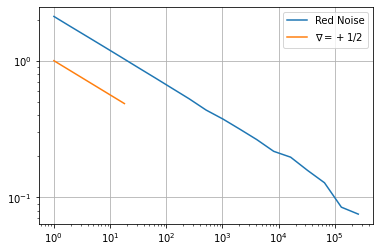

In [31]:
plt.loglog(t, a, label="Red Noise")
plt.loglog(x, y, label="$\\nabla=+1/2$")
plt.legend()
plt.grid(b=True)
plt.show();

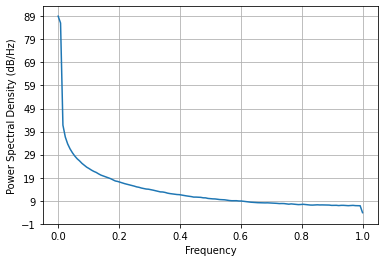

In [28]:
psd, freq = plt.psd(red_noise, NFFT=256)

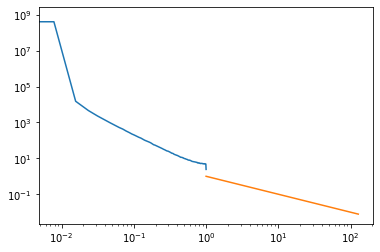

In [29]:
plt.loglog(freq, psd)
plt.loglog(np.arange(1, len(freq)), 1/np.power(np.arange(1, len(freq)), 1))